## Calculate Negative Selection returns and perform return analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import edhec_risk_kit as erk

In [2]:
# Name control files as well as relevant columns to process data
out_col_N = ['Date','Ticker','TR_1M','Neg_Sel','NS_Quintile']
control_N = pd.read_csv(r'C:\Users\B420615\OneDrive - Standard Bank\Py\Neg_Sel_Control.csv')
control_N = control_N['Files'].tolist()


In [3]:
# create file of negative selection alpha scores for all periods and output
Neg_Sel_Score = pd.DataFrame()
for file in control_N:
    try:
        data = pd.read_csv(rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\{file}.csv')
        Add_data = data[out_col_N].copy()
        Add_data['Date'] = Add_data['Date'].astype(int)
        Add_data['Date'] = pd.to_datetime(Add_data['Date'],format='%Y%m%d')
        Neg_Sel_Score = pd.concat([Neg_Sel_Score,Add_data],axis=0)
    
    except Exception as e:
        print(f"Error processing file {file}: {e}") 
       
#output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Neg_Sel_Alpha_Score.csv'
#Neg_Sel_Score.to_csv(output_file_path, index=False)

In [4]:
Neg_Sel_Score.tail()

,Date,Ticker,TR_1M,Neg_Sel,NS_Quintile
115,2025-10-31,RDF SJ Equity,8.65,-0.030344,3
116,2025-10-31,SNT SJ Equity,9.45,-0.153799,2
117,2025-10-31,AFH SJ Equity,7.02,-0.181701,2
118,2025-10-31,NED SJ Equity,10.61,-0.249803,1
119,2025-10-31,LTE SJ Equity,2.93,-0.016727,3


In [5]:
#Create a column that aligns future 1M returns with current selection (Future_TR)
Neg_Sel_Score['Future_TR'] = Neg_Sel_Score.groupby('Ticker')['TR_1M'].shift(-1)
Neg_Sel_Score = Neg_Sel_Score.sort_values(by=['Date'])
Alltime = list(set(Neg_Sel_Score['Date'])) # used set to eliminate duplicate values
output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Neg_Sel_Score.csv'
Neg_Sel_Score.to_csv(output_file_path, index=False)

In [6]:
Neg_Sel_Score.tail()

,Date,Ticker,TR_1M,Neg_Sel,NS_Quintile,Future_TR
32,2025-10-31,FBR SJ Equity,1.42,-0.130926,2,NaN
31,2025-10-31,KST SJ Equity,8.11,-0.031598,3,NaN
30,2025-10-31,SLM SJ Equity,8.83,0.019410,3,NaN
58,2025-10-31,PHP SJ Equity,4.28,-0.093827,3,NaN
119,2025-10-31,LTE SJ Equity,2.93,-0.016727,3,NaN


In [7]:
#Create a "liquid portfolio to eliminate illiquid stocks (defined by mkt cap). 
#Merge the liquidity filter dataframe and eliminate rows that do not meet liquidity requirements
liquidity_filter = 0.25
Jalsh_wts = pd.read_csv(rf'C:\Users\B420615\OneDrive - Standard Bank\Py\JalshWeightsBBG.csv')
Jalsh_wts["Date"] = pd.to_datetime(Jalsh_wts["Date"])
Jalsh_wts.rename(columns={'ID':'Ticker'},inplace=True)

Neg_Sel_Score_liquid = Neg_Sel_Score.merge(Jalsh_wts, on=['Date','Ticker'],how='left')
Neg_Sel_Score_liquid.drop(Neg_Sel_Score_liquid[Neg_Sel_Score_liquid['id().weights'] < liquidity_filter].index, inplace = True)


output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Neg_Sel_Score_liquid.csv'
Neg_Sel_Score_liquid.to_csv(output_file_path, index=False)



In [8]:
Neg_Sel_Score_liquid.tail()

,Date,Ticker,TR_1M,Neg_Sel,NS_Quintile,Future_TR,id().weights,ID_BB_GLOBAL
28388,2025-10-31,CPI SJ Equity,11.04,0.159244,4,NaN,4.029672,BBG000D4HYB1
28392,2025-10-31,SBK SJ Equity,7.69,-0.020071,3,NaN,4.086289,BBG000BQR991
28394,2025-10-31,BVT SJ Equity,6.21,-0.216023,2,NaN,0.934154,BBG000BFBR74
28397,2025-10-31,KST SJ Equity,8.11,-0.031598,3,NaN,0.293262,BBG006MCB4L1
28398,2025-10-31,SLM SJ Equity,8.83,0.019410,3,NaN,1.950051,BBG000CDQK77


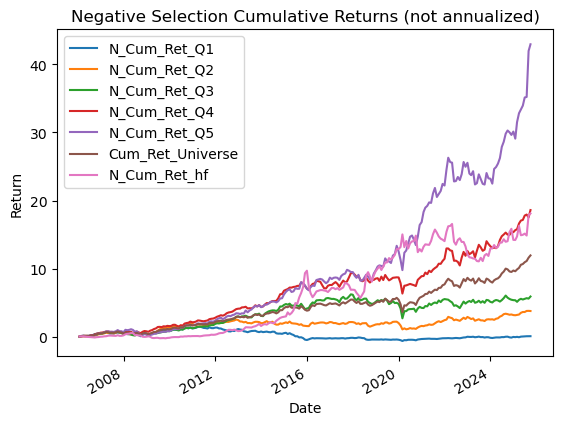

In [9]:
# Split data into quintiles, calculate quintile returns and graph quintile/universe performance - for Sentimentcomponent
averages = Neg_Sel_Score_liquid.groupby(['Date', 'NS_Quintile'])['Future_TR'].mean().unstack(fill_value=0)
averages.reset_index(inplace=True)
averages.columns.name = None
averages.columns = ['Date','N_Q1','N_Q2','N_Q3','N_Q4','N_Q5']
Universe = Neg_Sel_Score_liquid.groupby(['Date'])['Future_TR'].mean()
averages = pd.merge(averages, Universe, on='Date', how='outer')
averages.rename(columns={'Future_TR':'Universe'},inplace=True)
averages['N_hf_returns'] = averages['N_Q5'] - averages['N_Q1']
averages['N_Cum_Ret_Q1'] = (1+averages['N_Q1']/100).cumprod()-1
averages['N_Cum_Ret_Q2'] = (1+averages['N_Q2']/100).cumprod()-1
averages['N_Cum_Ret_Q3'] = (1+averages['N_Q3']/100).cumprod()-1
averages['N_Cum_Ret_Q4'] = (1+averages['N_Q4']/100).cumprod()-1
averages['N_Cum_Ret_Q5'] = (1+averages['N_Q5']/100).cumprod()-1
averages['Cum_Ret_Universe'] = (1+averages['Universe']/100).cumprod()-1
averages['N_Cum_Ret_hf'] = ((1+averages['N_hf_returns']/100).cumprod()-1)

ax = averages.plot(xlabel='Date', ylabel='Return',x = 'Date',y = ['N_Cum_Ret_Q1','N_Cum_Ret_Q2','N_Cum_Ret_Q3','N_Cum_Ret_Q4','N_Cum_Ret_Q5','Cum_Ret_Universe','N_Cum_Ret_hf'])
ax.set_title('Negative Selection Cumulative Returns (not annualized)')

# Create a dataframe of average returns to be used to calculate the IC score
Ave_returns = averages[['Date', 'Universe']].copy()
# Create output file
output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Neg_Sel_Q_Scores_liquid.csv'
averages.to_csv(output_file_path, index=False)

In [10]:
Universe = Universe.to_frame(name='Universe_ret')
Universe.head()

,Universe_ret
Date,
2006-01-31,0.503286
2006-02-28,6.999608
2006-03-31,3.072400
2006-04-30,-1.228800
2006-05-31,0.321190


In [11]:
#Show annualised returns
last_row_series = ((1+(averages.iloc[-2][['N_Cum_Ret_Q1','N_Cum_Ret_Q2','N_Cum_Ret_Q3','N_Cum_Ret_Q4',
                                         'N_Cum_Ret_Q5','Cum_Ret_Universe','N_Cum_Ret_hf']]))**(12/235)-1)*100
last_row_series
#fig,ax = plt.subplots(figsize = (12,8))
#returns = sns.barplot(y = last_row_series,x=last_row_series.index ,color = sns.color_palette()[0],saturation=1.)

N_Cum_Ret_Q1         0.375257
N_Cum_Ret_Q2         8.309375
N_Cum_Ret_Q3        10.367227
N_Cum_Ret_Q4        16.408783
N_Cum_Ret_Q5        21.309505
Cum_Ret_Universe    13.966663
N_Cum_Ret_hf        16.257813
Name: 235, dtype: object

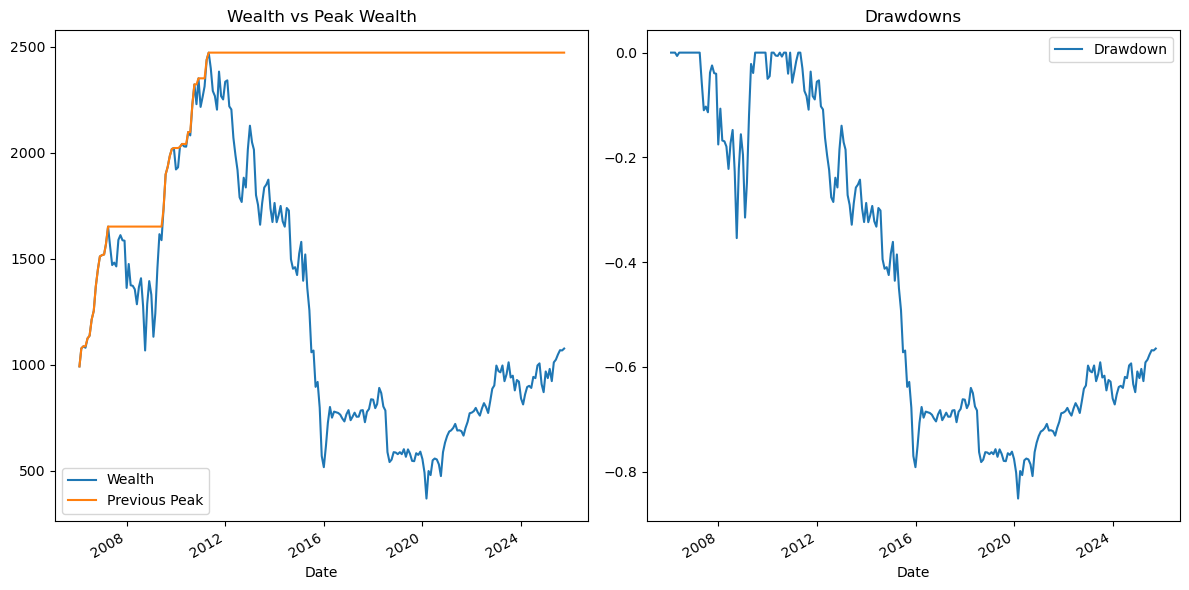

In [12]:
#Calculate drawdowns
Drawdowns = erk.drawdown(averages['N_Q1']/100)
Drawdowns = pd.merge(Drawdowns, averages['Date'], left_index=True,right_index=True)
Drawdowns = Drawdowns.reindex(['Date', 'Wealth', 'Previous Peak','Drawdown'], axis=1)
Drawdowns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
Drawdowns.plot(x='Date',y=['Wealth','Previous Peak'],ax=axes[0])
axes[0].set_title('Wealth vs Peak Wealth')

Drawdowns.plot(x='Date',y='Drawdown',ax=axes[1])
axes[1].set_title('Drawdowns')

plt.tight_layout()
plt.show()
                  
#ax = Drawdowns.plot(xlabel='Months', ylabel='Wealth',x='Date',y = ['Wealth','Previous Peak'])
#ax.set_title('Wealth vs Peak Wealth')


In [13]:
# Sharpe Ratio
erk.sharpe_ratio(averages['N_Q1']/100, 0, 12)

np.float64(0.014720237544544369)

In [14]:
#Isolate the Short portfolio through time - output 'Shorts' file
filtered_df = pd.DataFrame()
for date in Alltime:
    #Filter rows for the date and specified integer value
    temp_df = Neg_Sel_Score_liquid[(Neg_Sel_Score_liquid['Date'] == date) & (Neg_Sel_Score_liquid['NS_Quintile'] == 1) ]
    filtered_df = pd.concat([filtered_df, temp_df], ignore_index=True)
    filtered_df = filtered_df.sort_values(by=['Date'])

output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Shorts_liquid.csv'
filtered_df.to_csv(output_file_path, index=False)

In [15]:
# Universe_returns has columns: ['Date', 'Universe_Return']

# Step 1: Merge universe returns with your main dataframe
df_merged = Neg_Sel_Score_liquid.merge(Universe, on='Date', how='left')

# Step 2: Filter for 5th quintile only
q1_df = df_merged[df_merged['NS_Quintile'] == 1].copy()

# Step 3: Create a column to check if stock beat universe
q1_df['Beat_Universe'] = (q1_df['Future_TR'] < q1_df['Universe_ret']).astype(int)

# Step 4: Calculate monthly IC (hit rate)
monthly_hits = q1_df.groupby('Date').agg({
    'Beat_Universe': ['sum', 'count']
})

# Step 4: Calculate monthly IC (hit rate)
monthly_hits = q1_df.groupby('Date').agg({
    'Beat_Universe': ['sum', 'count']
})
monthly_hits.columns = ['Beats', 'Total_Stocks']
monthly_hits['Monthly_IC'] = (2*monthly_hits['Beats'] / monthly_hits['Total_Stocks'])-1

# Step 5: Calculate cumulative IC
monthly_hits['Cumulative_IC'] = monthly_hits['Monthly_IC'].cumsum()

# Reset index to make Date a column
monthly_hits = monthly_hits.reset_index()
Overall_ic = monthly_hits[0:-2]['Monthly_IC'].mean(axis=0)
monthly_hits['ic_12M'] = monthly_hits['Monthly_IC'].rolling(window=12, min_periods=12).mean()

Overall_ic


np.float64(0.1425442369003399)

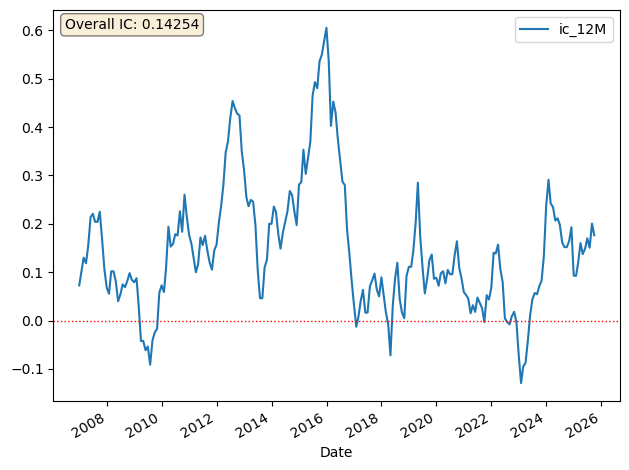

In [16]:
monthly_hits.loc[0:235].plot(x='Date',y=['ic_12M'])
plt.axhline(y=0, color='red', linestyle=':', linewidth=1)

plt.text(0.02, 0.98, f'Overall IC: {Overall_ic:.5}', 
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()